In [100]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
alt.data_transformers.disable_max_rows()
alt.display.renderers.enable('svg')
import matplotlib.pyplot as plt

import act
import act.discovery, act.io

import metpy.calc, metpy.constants
from metpy.units import units
import glob
from tqdm import tqdm
from sublimpy import utils
import datetime as dt
from functools import reduce

from metpy.units import units
def w_tc_to_watts(values):
    specific_heat_capacity_air = 1.0005 * units('kilojoules/(K*kg)')
    air_density = 1 * units("kg/m^3")
    sensible_heat_flux_meas_units = values * units("K*m/s")
    return (sensible_heat_flux_meas_units * specific_heat_capacity_air * air_density).to("W/m^2").magnitude
def w_h2o_to_watts(values):
    latent_heat_of_vaporization = 2838 * units("J/g")
    latent_heat_flux_meas_units = values * units("g/(m^2 * s)")
    return (latent_heat_flux_meas_units * latent_heat_of_vaporization).to("W/m^2").magnitude

Select date range

In [2]:
# for SAIL data queries
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
start_date = "20221130"
end_date = "20230616"
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/"

from datetime import datetime, timedelta

def generate_date_range(start_date, end_date):
    # Parse the input dates
    start = datetime.strptime(start_date, '%Y%m%d')
    end = datetime.strptime(end_date, '%Y%m%d')
    
    # Generate the list of dates
    date_list = []
    current_date = start
    while current_date <= end:
        date_list.append(current_date.strftime('%Y%m%d'))
        current_date += timedelta(days=1)
    
    return date_list
dates = generate_date_range(start_date, end_date)[:-1]
dates

['20221130',
 '20221201',
 '20221202',
 '20221203',
 '20221204',
 '20221205',
 '20221206',
 '20221207',
 '20221208',
 '20221209',
 '20221210',
 '20221211',
 '20221212',
 '20221213',
 '20221214',
 '20221215',
 '20221216',
 '20221217',
 '20221218',
 '20221219',
 '20221220',
 '20221221',
 '20221222',
 '20221223',
 '20221224',
 '20221225',
 '20221226',
 '20221227',
 '20221228',
 '20221229',
 '20221230',
 '20221231',
 '20230101',
 '20230102',
 '20230103',
 '20230104',
 '20230105',
 '20230106',
 '20230107',
 '20230108',
 '20230109',
 '20230110',
 '20230111',
 '20230112',
 '20230113',
 '20230114',
 '20230115',
 '20230116',
 '20230117',
 '20230118',
 '20230119',
 '20230120',
 '20230121',
 '20230122',
 '20230123',
 '20230124',
 '20230125',
 '20230126',
 '20230127',
 '20230128',
 '20230129',
 '20230130',
 '20230131',
 '20230201',
 '20230202',
 '20230203',
 '20230204',
 '20230205',
 '20230206',
 '20230207',
 '20230208',
 '20230209',
 '20230210',
 '20230211',
 '20230212',
 '20230213',
 '20230214',

# Load observations

## SOS towers

In [3]:
sos_df = pd.read_parquet("../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet")
sos_df_localtime = utils.modify_df_timezone(
    sos_df,
    'UTC',
    'US/Mountain'
)
sos_df_localtime = sos_df_localtime[sos_df_localtime.time >= start_date]
sos_df_localtime = sos_df_localtime[sos_df_localtime.time < end_date]
sos_df_localtime.time.min(), sos_df_localtime.time.max()

(Timestamp('2022-11-30 00:00:00'), Timestamp('2023-06-15 23:30:00'))

## SAIL Rawinsondes - extract mean 1-1.5km absolute humidity.

GET 30min 1--1.5km abs. humidity from radiosondes (apply 0430 value to 0000-1200, 1630 value to 1200-2400)

In [4]:
# Define the data code and date range
sonde_data_code = 'gucsondewnpnM1.b1'
# Download the data
# files = act.discovery.download_arm_data(
#     username,
#     token,
#     sonde_data_code,
#     start_date,
#     end_date,
#     output = os.path.join(data_dir, sonde_data_code)
# )
# files = sorted(files)

In [5]:
files = pd.Series(dates).apply(
    lambda d: glob.glob(os.path.join(data_dir, sonde_data_code, f"*{d}*.cdf"))
)
files = [x for x in list(files.explode()) if type(x)==str]
files = sorted(files)
len(files), len(dates)

(395, 198)

In [26]:
sondes_ds = xr.open_mfdataset(files)
sondes_df = sondes_ds.to_dataframe().reset_index()
sondes_df = utils.modify_df_timezone(sondes_df, 'UTC', 'US/Mountain')
sondes_df['date'] = sondes_df.time.dt.date.astype(str)
sondes_df['hour'] = sondes_df.time.dt.hour
sondes_df['timeofday'] = (sondes_df['hour'] < 12).apply(lambda is_morning: 'Morning' if is_morning else 'Afternoon')
sondes_df['height'] = sondes_df.alt - 2891
sondes_df = sondes_df[
    (sondes_df.height >= 1000)
    &
    (sondes_df.height <= 1500)
]

In [27]:
sondes_df = utils.modify_df_timezone(sondes_df, 'UTC', 'US/Mountain')

h2o_mixing_ratio = metpy.calc.mixing_ratio_from_relative_humidity(
    sondes_df.pres.values * units("millibars"),
    sondes_df.tdry.values * units('degC'),
    sondes_df.rh.values * units("percent")
)
dry_air_density = metpy.calc.density(
    sondes_df.pres.values * units("millibars"),
    sondes_df.tdry.values * units('degC'),
    0
)
sondes_df['abs_humidity'] = (h2o_mixing_ratio * dry_air_density).to(units('g/m^3'))
sondes_df = sondes_df.groupby(['date', 'timeofday'])['abs_humidity'].mean().reset_index()


In [28]:
time_mapping = {"Afternoon": "1630", "Morning": "0430"}
sondes_df['time'] = sondes_df['date'].astype(str) + " " + sondes_df['timeofday'].map(time_mapping)
sondes_df['time'] = pd.to_datetime(sondes_df['time'])
sondes_df = sondes_df.set_index('time')[['abs_humidity']]
# Reindex sondes_df to the new index, filling missing data with the nearest neighbor
new_index = pd.date_range(start=start_date, end=end_date, freq='30min')
sondes_df = sondes_df.sort_index().reindex(new_index, method='nearest')

<Axes: >

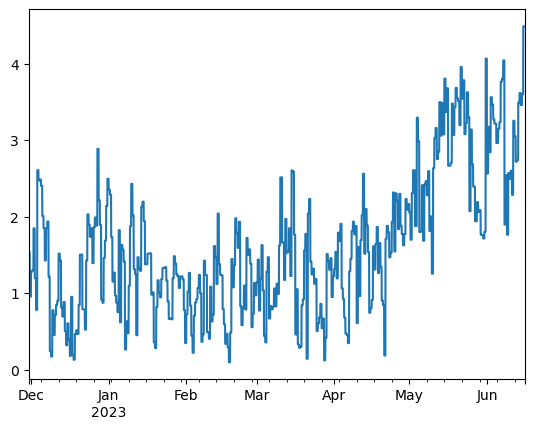

In [31]:
sondes_df.abs_humidity.plot()

## Doppler Lidar - extract mean 1-1.5km horizontal wind speed

In [32]:
# Inputs
DLWProf_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DLWProf_DATA_STREAM_FILEEXT = '.cdf'
DLWProf_OUTPUT_DIR = os.path.join(data_dir, DLWProf_DATA_STREAM)
# file_list = act.discovery.download_arm_data(
#             username, token, DLWProf_DATA_STREAM, start_date, end_date, output = DLWProf_OUTPUT_DIR)
# dl_wprof = xr.open_mfdataset(file_list)

In [69]:
file_list = sorted(list(
    pd.Series(dates).apply(lambda d: glob.glob(os.path.join(DLWProf_OUTPUT_DIR, f"*{d}*.nc"))).explode()
))
dl_wprof = xr.open_mfdataset(file_list, chunks={'time':-1, 'height': 100})
dl_wprof = dl_wprof.sel(height = slice(1000,1500))
dl_wprof = dl_wprof['wind_speed'].mean('height').compute()
dl_wprof = dl_wprof.resample(time='30min').mean()

In [91]:
dl_wprof_df = dl_wprof.to_dataframe().reset_index()

In [96]:
dl_wprof_df_localtime = utils.modify_df_timezone(dl_wprof_df, 'UTC', 'US/Mountain')

In [97]:
dl_wprof_df.head(30)

,time,wind_speed
0,2022-11-30 00:00:00,9.096486
1,2022-11-30 00:30:00,12.832873
2,2022-11-30 01:00:00,NaN
3,2022-11-30 01:30:00,NaN
4,2022-11-30 02:00:00,NaN
5,2022-11-30 02:30:00,9.339062
6,2022-11-30 03:00:00,6.775637
7,2022-11-30 03:30:00,NaN
8,2022-11-30 04:00:00,NaN
9,2022-11-30 04:30:00,NaN


## Tropoe?

In [124]:
# tropoe_ds = xr.open_mfdataset([
#     "/Users/elischwat/Development/data/sublimationofsnow/tropoe_from_bianca/gucM1tropoeAERI.raso_ctrl.20230418.001005.nc",
#     "/Users/elischwat/Development/data/sublimationofsnow/tropoe_from_bianca/gucM1tropoeAERI.raso_ctrl.20230419.001005.nc",
# ])
# tropoe_df = tropoe_ds[['theta', 'waterVapor', 'pressure', 'temperature']].to_dataframe().reset_index()
# tropoe_df = utils.modify_df_timezone(tropoe_df, 'UTC', 'US/Mountain')
# tropoe_df['height'] = tropoe_df['height']*1000
# dry_air_density = metpy.calc.density(
#     pressure = tropoe_df['pressure'].values * units("millibars"), 
#     temperature = tropoe_df['temperature'].values * units('degC'),
#     mixing_ratio=0
# )
# abs_humidity = tropoe_df['waterVapor']*units('g/kg') * dry_air_density
# tropoe_df['abs_humidity'] = abs_humidity

## Modeled fluxes

In [119]:
modeled_fluxes_df = pd.read_parquet("/Users/elischwat/Development/sublimationofsnow/analysis/paper1_old/coare_model_results.parquet")
modeled_fluxes_df = modeled_fluxes_df.query("config == 'Tsurf_c e_sat_alduchov 0.0001 3m'")

In [120]:
modeled_fluxes_df_localtime = utils.modify_df_timezone(
    modeled_fluxes_df.reset_index(), 'UTC', 'US/Mountain'
).set_index('time').sort_index()

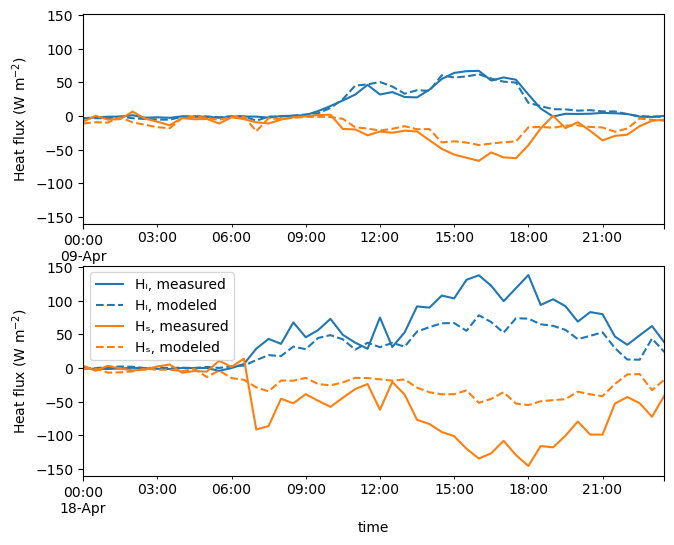

In [121]:
fig, axes = plt.subplots(2, 1, figsize=(7.5,6), sharey=True)

w_tc_measured_series = sos_df_localtime.query("variable == 'w_tc__3m_c'").set_index('time').sort_index()[['value']]
w_tc_measured_series.value = w_tc_to_watts(w_tc_measured_series.value.values)

w_h2o_measured_series = sos_df_localtime.query("variable == 'w_h2o__3m_c_raw'").set_index('time').sort_index()[['value']]
w_h2o_measured_series.value = w_h2o_to_watts(w_h2o_measured_series.value.values)

w_h2o_measured_series['value'].loc[start_date: end_date].loc['20230409'].plot(label='Hₗ, measured', color='tab:blue', ax=axes[0])
modeled_fluxes_df_localtime['hlb'].loc[start_date: end_date].loc['20230409'].plot(label='Hₗ, modeled', color='tab:blue', linestyle='--', ax=axes[0])
w_tc_measured_series['value'].loc[start_date: end_date].loc['20230409'].plot(label='Hₛ, measured', color='tab:orange', ax=axes[0])
modeled_fluxes_df_localtime['hsb'].loc[start_date: end_date].loc['20230409'].plot(label='Hₛ, modeled', color='tab:orange', linestyle='--', ax=axes[0])

w_h2o_measured_series['value'].loc[start_date: end_date].loc['20230418'].plot(label='Hₗ, measured', color='tab:blue', ax=axes[1])
modeled_fluxes_df_localtime['hlb'].loc[start_date: end_date].loc['20230418'].plot(label='Hₗ, modeled', color='tab:blue', linestyle='--', ax=axes[1])
w_tc_measured_series['value'].loc[start_date: end_date].loc['20230418'].plot(label='Hₛ, measured', color='tab:orange', ax=axes[1])
modeled_fluxes_df_localtime['hsb'].loc[start_date: end_date].loc['20230418'].plot(label='Hₛ, modeled', color='tab:orange', linestyle='--', ax=axes[1])

for ax in axes:
    ax.set_ylabel("Heat flux (W m$^{-2}$)")
plt.legend()

In [122]:
meas_mod_df = pd.concat([
    pd.DataFrame(w_h2o_measured_series['value'].loc[start_date: end_date].loc['20230409'].rename('measured')).join(
        modeled_fluxes_df_localtime['hlb'].loc[start_date: end_date].loc['20230409'].rename('modeled')
    ).assign(variable = 'Hl'),
    pd.DataFrame(w_tc_measured_series['value'].loc[start_date: end_date].loc['20230409'].rename('measured')).join(
        modeled_fluxes_df_localtime['hsb'].loc[start_date: end_date].loc['20230409'].rename('modeled'),
    ).assign(variable = 'Hs'),
    pd.DataFrame(w_h2o_measured_series['value'].loc[start_date: end_date].loc['20230418'].rename('measured')).join(
        modeled_fluxes_df_localtime['hlb'].loc[start_date: end_date].loc['20230418'].rename('modeled')
    ).assign(variable = 'Hl'),
    pd.DataFrame(w_tc_measured_series['value'].loc[start_date: end_date].loc['20230418'].rename('measured')).join(
        modeled_fluxes_df_localtime['hsb'].loc[start_date: end_date].loc['20230418'].rename('modeled'),
    ).assign(variable = 'Hs')
])
meas_mod_df

,measured,modeled,variable
time,,,
2023-04-09 00:00:00,-3.248011,-3.584159,Hl
2023-04-09 00:30:00,-2.030060,-3.119693,Hl
2023-04-09 01:00:00,-0.907901,-3.303994,Hl
2023-04-09 01:30:00,-0.822435,-0.604974,Hl
2023-04-09 02:00:00,1.316493,-3.204003,Hl
...,...,...,...
2023-04-18 21:30:00,-52.760040,-23.570928,Hs
2023-04-18 22:00:00,-43.050481,-9.473764,Hs
2023-04-18 22:30:00,-52.159834,-8.943932,Hs


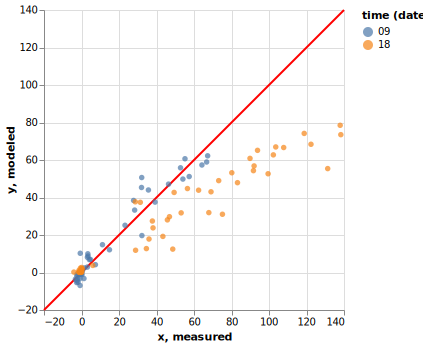

In [123]:
one_to_one = alt.Chart(pd.DataFrame({'x': [-20, 140], 'y': [-20, 140]})).mark_line(color='red').encode(
    x='x:Q',
    y='y:Q'
)


one_to_one + alt.Chart(meas_mod_df.query("variable == 'Hl'").reset_index()).mark_circle().encode(
    alt.X('measured:Q').scale(domain=[-20,140]),
    alt.Y('modeled:Q').scale(domain=[-20,140]),
    alt.Color('date(time):N'),
)

# MODEL NON LOCAL ADVECTIVE FLUX

$$\overline{w'\phi'} \approx - K \frac{\partial \overline{\phi}}{\partial z} + \frac{L}{T V} w (\phi_{up} - \overline{\phi})$$

Get $L$ and $T$

In [224]:
# term 1 is from above
L = 250 * units("meters")
T = 200 * units("seconds")

Get $V$

In [225]:
model_df = dl_wprof_df.set_index('time').copy()

In [226]:
model_df['alpha'] = (L / (
    T * V_df.wind_speed.values * units("m/s")
)).magnitude

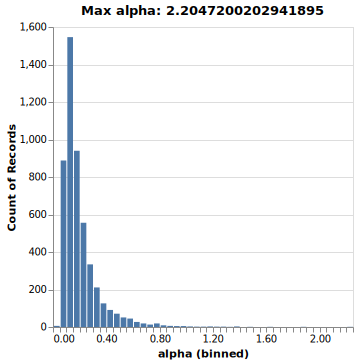

In [227]:
alt.Chart(model_df).mark_bar().encode(
    alt.X('alpha:Q').bin(step=0.05),
    alt.Y('count()')
).properties(title = f"Max alpha: {model_df.alpha.dropna().max()}")

Get $w$

In [228]:
# GET 30min w_20m_c from SOS site
w_df = sos_df.query("variable == 'w_20m_c'")[['time','value']].set_index('time')

In [229]:
model_df = model_df.join(w_df.value.rename('w'))


Get $\phi_{up}$

In [230]:
model_df = model_df.join(sondes_df['abs_humidity'].rename('phi_up'))

Get $\phi$

In [231]:
# phi = # GET 30min 3 meter abs. humidity from SOS data
# GET 30min w_20m_c from SOS site
phi_df = (
    sos_df.query("variable == 'mixingratio_2m_c'")[['time','value']].set_index('time')
    *
    sos_df.query("variable == 'dryairdensity_2m_c'")[['time','value']].set_index('time')
)*1000

In [232]:
model_df = model_df.join(phi_df.value.rename('phi'))

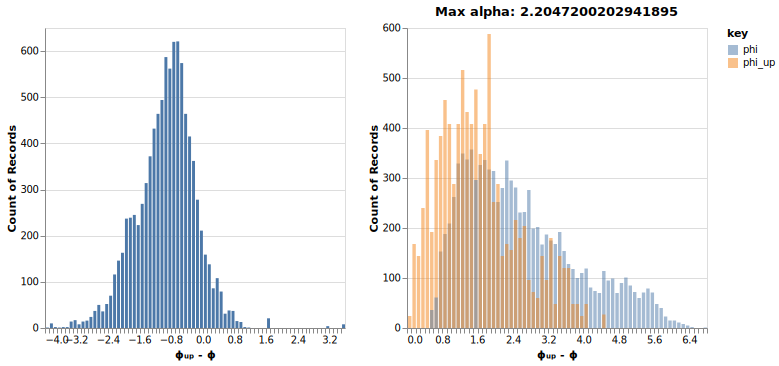

In [233]:
alt.Chart(model_df).transform_calculate(
    phi_diff = 'datum.phi_up - datum.phi'
).mark_bar().encode(
    alt.X('phi_diff:Q').bin(step=0.1).title('ϕᵤₚ - ϕ'),
    alt.Y('count()')
) | alt.Chart(model_df).transform_fold(
    ['phi_up', 'phi']
).mark_bar(opacity=0.5,).encode(
    alt.X('value:Q').bin(step=0.1).title('ϕᵤₚ - ϕ'),
    alt.Y('count()').stack(None),
    alt.Color('key:N')
).properties(title = f"Max alpha: {model_df.alpha.dropna().max()}")

Combine all to calculate non-local transport

$$ \frac{L}{T V} w (\phi_{up} - \overline{\phi})$$

In [234]:
model_df['w'] = model_df['w'].apply(
    lambda w: 0 if w > 0 else w
)

In [235]:
model_df.head(3)

,wind_speed,alpha,w,phi_up,phi
time,,,,,
2022-11-30 00:00:00,9.096486,0.137416,-0.03864,1.542133,1.241137
2022-11-30 00:30:00,12.832873,0.097406,0.00000,1.542133,0.943030
2022-11-30 01:00:00,NaN,NaN,0.00000,1.542133,0.911426


In [236]:
nonlocal_transport_results = (
    0.1 * (model_df['w'].values*units('meters/second')) * (
    (model_df['phi_up'].values*units('g/m^3'))
    - (model_df['phi'].values*units('g/m^3'))
))
nonlocal_transport_results

Magnitude,[-0.0011630425703292014 0.0 0.0 ... 0.019005485694906232 0.002834279206679638 0.008603134565883712]
Units,gram/(meter2 second)


In [237]:
model_df['nonlocal_hl'] = w_h2o_to_watts(nonlocal_transport_results.magnitude)

In [254]:
model_df = model_df.join(modeled_fluxes_df_localtime[['hsb', 'hlb']].rename(
    columns = {'hsb':'local_hs', 'hlb':'local_hl'}
))

In [263]:
model_df['combined_hl'] = model_df[['nonlocal_hl', 'local_hl']].sum(axis=1)

<Axes: xlabel='time'>

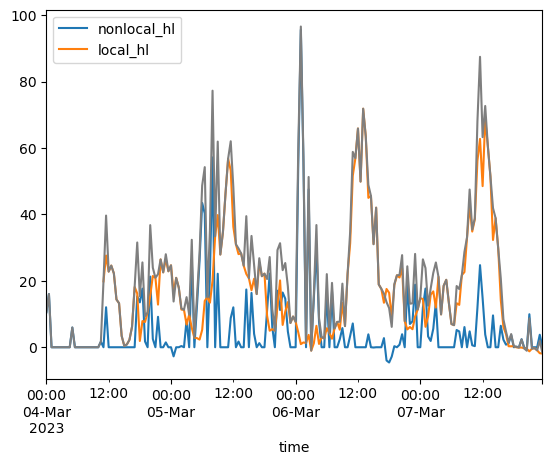

In [269]:
model_df.loc['20230304':'20230307':][['nonlocal_hl', 'local_hl']].plot()
model_df.loc['20230304':'20230307':]['combined_hl'].plot(color='tab:grey')

Add in measurements

In [279]:
hl_meaured_df = sos_df_localtime.query("variable == 'w_h2o__3m_c_raw'").set_index('time').sort_index()['value'].rename('measured_hl')
hl_meaured_df = hl_meaured_df.apply(w_h2o_to_watts)

In [280]:
model_df = model_df.join(hl_meaured_df)

# Plot results

Get categories

In [301]:
along_valley_wind_times = pd.read_csv('along_valley_wind_times.csv')['0']
cross_valley_wind_times = pd.read_csv('cross_valley_wind_times.csv')['0']
fast_wind_times = pd.read_csv('winds_ge10_times.csv')['time']
slow_wind_times = pd.read_csv('winds_le10_times.csv')['time']

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_94423/1070043552.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  subset_xvalley = model_df[model_df.index.isin(cross_valley_wind_times)]  # Replace 'condition' and 'A' with actual column and value
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_94423/1070043552.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  subset_alongvalley = model_df[model_df.index.isin(along_valley_wind_times)]  # Replace 'condition' and 'B' with actual column and value


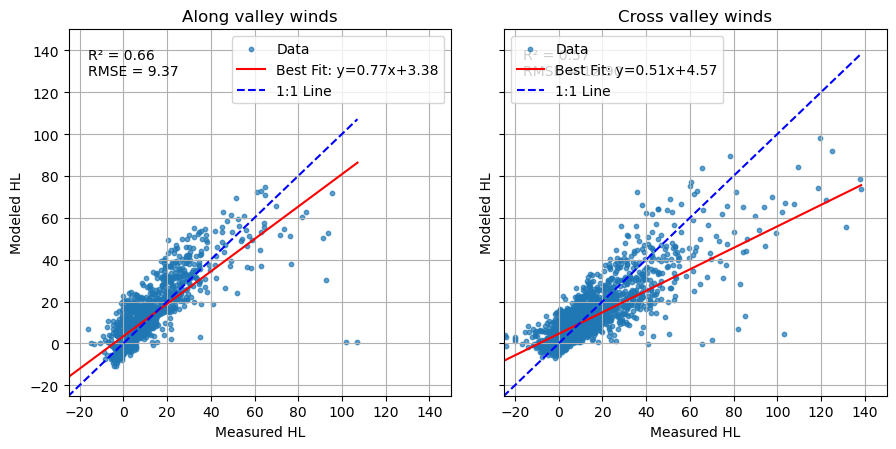

In [316]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

src = model_df

# Define subsets
subset_xvalley = model_df[model_df.index.isin(cross_valley_wind_times)]  # Replace 'condition' and 'A' with actual column and value
subset_alongvalley = model_df[model_df.index.isin(along_valley_wind_times)]  # Replace 'condition' and 'B' with actual column and value

# Function to create a plot for a subset
def plot_subset(data, ax, title):
    measured = data[['measured_hl', 'local_hl']].dropna()['measured_hl']
    modeled = data[['local_hl', 'measured_hl']].dropna()['local_hl']

    # Calculate statistics
    slope, intercept, r_value, p_value, std_err = linregress(measured, modeled)
    rmse = np.sqrt(mean_squared_error(measured, modeled))
    r_squared = r_value**2

    # Scatter plot
    ax.scatter(measured, modeled, label='Data', alpha=0.7, s=10)

    # Line of best fit
    x = np.linspace(min(measured), max(measured), 100)
    y = slope * x + intercept
    ax.plot(x, y, color='red', label=f'Best Fit: y={slope:.2f}x+{intercept:.2f}')

    # 1:1 line
    ax.plot(x, x, color='blue', linestyle='--', label='1:1 Line')

    # Add statistics as text
    ax.text(0.05, 0.95, f'R² = {r_squared:.2f}\nRMSE = {rmse:.2f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top')

    # Customize plot
    ax.set_xlabel('Measured HL')
    ax.set_ylabel('Modeled HL')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(-25, 150)
    ax.set_ylim(-25, 150)
    ax.grid(True)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(9.2, 4.6), sharex=True, sharey=True)

plot_subset(subset_alongvalley, axes[0], 'Along valley winds')
plot_subset(subset_xvalley, axes[1], 'Cross valley winds')


plt.tight_layout()
plt.show()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_94423/2137772871.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  subset_xvalley = model_df[model_df.index.isin(cross_valley_wind_times)]  # Replace 'condition' and 'A' with actual column and value
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_94423/2137772871.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  subset_alongvalley = model_df[model_df.index.isin(along_valley_wind_times)]  # Replace 'condition' and 'B' with actual column and value


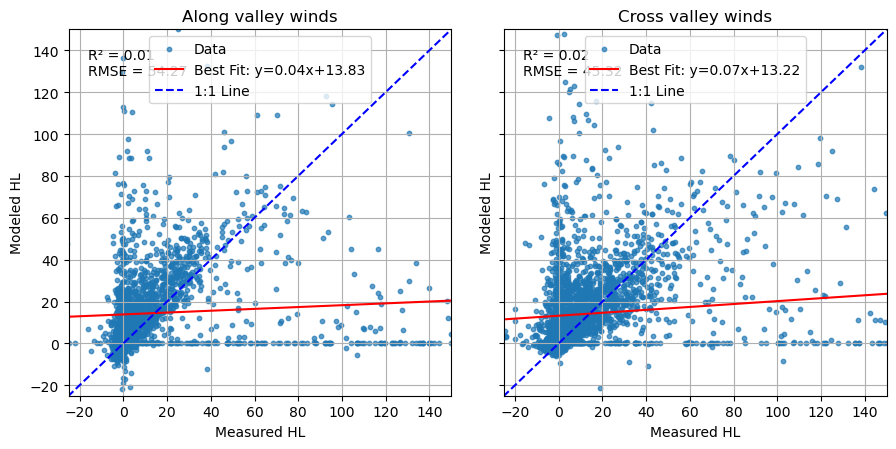

In [318]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

src = model_df

# Define subsets
subset_xvalley = model_df[model_df.index.isin(cross_valley_wind_times)]  # Replace 'condition' and 'A' with actual column and value
subset_alongvalley = model_df[model_df.index.isin(along_valley_wind_times)]  # Replace 'condition' and 'B' with actual column and value

# Function to create a plot for a subset
def plot_subset(data, ax, title):
    measured = data[['measured_hl', 'combined_hl']].dropna()['measured_hl']
    modeled = data[['combined_hl', 'measured_hl']].dropna()['combined_hl']

    # Calculate statistics
    slope, intercept, r_value, p_value, std_err = linregress(measured, modeled)
    rmse = np.sqrt(mean_squared_error(measured, modeled))
    r_squared = r_value**2

    # Scatter plot
    ax.scatter(measured, modeled, label='Data', alpha=0.7, s=10)

    # Line of best fit
    x = np.linspace(min(measured), max(measured), 100)
    y = slope * x + intercept
    ax.plot(x, y, color='red', label=f'Best Fit: y={slope:.2f}x+{intercept:.2f}')

    # 1:1 line
    ax.plot(x, x, color='blue', linestyle='--', label='1:1 Line')

    # Add statistics as text
    ax.text(0.05, 0.95, f'R² = {r_squared:.2f}\nRMSE = {rmse:.2f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top')

    # Customize plot
    ax.set_xlabel('Measured HL')
    ax.set_ylabel('Modeled HL')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(-25, 150)
    ax.set_ylim(-25, 150)
    ax.grid(True)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(9.2, 4.6), sharex=True, sharey=True)

plot_subset(subset_alongvalley, axes[0], 'Along valley winds')
plot_subset(subset_xvalley, axes[1], 'Cross valley winds')


plt.tight_layout()
plt.show()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_94423/1312468987.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  subset_xvalley = model_df[model_df.index.isin(cross_valley_wind_times)]  # Replace 'condition' and 'A' with actual column and value
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_94423/1312468987.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  subset_xvalley = subset_xvalley[subset_xvalley.index.isin(fast_wind_times)]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_94423/1312468987.py:11: FutureWarning: The behavior of 'isin

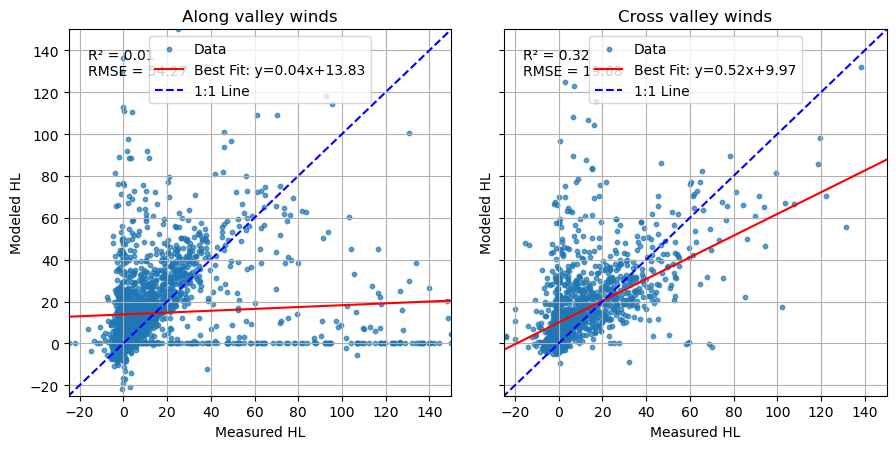

In [324]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

src = model_df

# Define subsets
subset_xvalley = model_df[model_df.index.isin(cross_valley_wind_times)]  # Replace 'condition' and 'A' with actual column and value
subset_xvalley = subset_xvalley[subset_xvalley.index.isin(fast_wind_times)]
subset_alongvalley = model_df[model_df.index.isin(along_valley_wind_times)]  # Replace 'condition' and 'B' with actual column and value

# Function to create a plot for a subset
def plot_subset(data, ax, title):
    measured = data[['measured_hl', 'combined_hl']].dropna()['measured_hl']
    modeled = data[['combined_hl', 'measured_hl']].dropna()['combined_hl']

    # Calculate statistics
    slope, intercept, r_value, p_value, std_err = linregress(measured, modeled)
    rmse = np.sqrt(mean_squared_error(measured, modeled))
    r_squared = r_value**2

    # Scatter plot
    ax.scatter(measured, modeled, label='Data', alpha=0.7, s=10)

    # Line of best fit
    x = np.linspace(min(measured), max(measured), 100)
    y = slope * x + intercept
    ax.plot(x, y, color='red', label=f'Best Fit: y={slope:.2f}x+{intercept:.2f}')

    # 1:1 line
    ax.plot(x, x, color='blue', linestyle='--', label='1:1 Line')

    # Add statistics as text
    ax.text(0.05, 0.95, f'R² = {r_squared:.2f}\nRMSE = {rmse:.2f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top')

    # Customize plot
    ax.set_xlabel('Measured HL')
    ax.set_ylabel('Modeled HL')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(-25, 150)
    ax.set_ylim(-25, 150)
    ax.grid(True)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(9.2, 4.6), sharex=True, sharey=True)

plot_subset(subset_alongvalley, axes[0], 'Along valley winds')
plot_subset(subset_xvalley, axes[1], 'Cross valley winds')


plt.tight_layout()
plt.show()

<Axes: xlabel='time'>

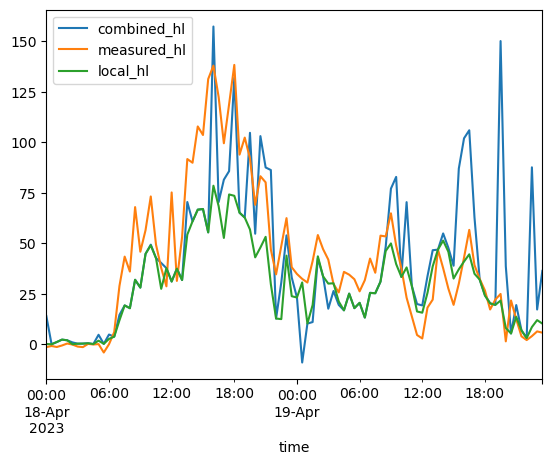

In [337]:
model_df.loc['20230418':'20230419':][['combined_hl', 'measured_hl', 'local_hl']].plot()

Identify times when Co(u'w') is positive - that's when we will apply the correction

In [338]:
uw_mrds_df = pd.read_parquet("mrds/uw")
uw_mrds_df['middle_time'] = uw_mrds_df['start_time'] + (uw_mrds_df['end_time'] - uw_mrds_df['start_time']) / 2

In [345]:
mean_uw_mrds_df = uw_mrds_df.groupby('middle_time')['Co'].mean().resample('30min').mean()

In [352]:
times_with_positive_uw = mean_uw_mrds_df[mean_uw_mrds_df > 0].index
times_with_negative_uw = mean_uw_mrds_df[mean_uw_mrds_df < 0].index

Only look at times when mean[Co(u'w')] > 0

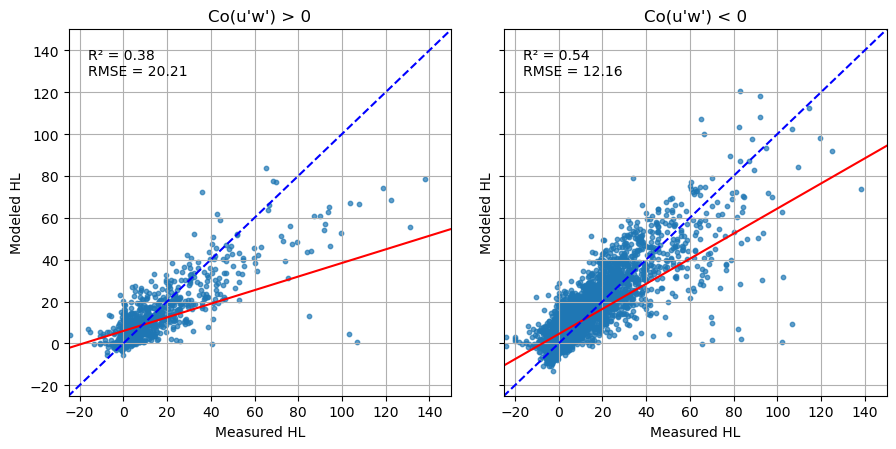

In [357]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

src = model_df

# Define subsets
subset_during_pos_uw = model_df[model_df.index.isin(times_with_positive_uw)] # Replace 'condition' and 'A' with actual column and value
subset_during_neg_uw = model_df[model_df.index.isin(times_with_negative_uw)]  # Replace 'condition' and 'B' with actual column and value

# Function to create a plot for a subset
def plot_subset(data, ax, title):
    measured = data[['measured_hl', 'local_hl']].dropna()['measured_hl']
    modeled = data[['local_hl', 'measured_hl']].dropna()['local_hl']

    # Calculate statistics
    slope, intercept, r_value, p_value, std_err = linregress(measured, modeled)
    rmse = np.sqrt(mean_squared_error(measured, modeled))
    r_squared = r_value**2

    # Scatter plot
    ax.scatter(measured, modeled, label='Data', alpha=0.7, s=10)

    # Line of best fit
    x = np.linspace(min(measured), max(measured), 100)
    y = slope * x + intercept
    ax.plot(x, y, color='red', label=f'Best Fit: y={slope:.2f}x+{intercept:.2f}')

    # 1:1 line
    ax.plot(x, x, color='blue', linestyle='--', label='1:1 Line')

    # Add statistics as text
    ax.text(0.05, 0.95, f'R² = {r_squared:.2f}\nRMSE = {rmse:.2f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top')

    # Customize plot
    ax.set_xlabel('Measured HL')
    ax.set_ylabel('Modeled HL')
    ax.set_title(title)
    # ax.legend()
    ax.set_xlim(-25, 150)
    ax.set_ylim(-25, 150)
    ax.grid(True)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(9.2, 4.6), sharex=True, sharey=True)

plot_subset(subset_during_pos_uw, axes[0], "Co(u'w') > 0")
plot_subset(subset_during_neg_uw, axes[1], "Co(u'w') < 0")


plt.tight_layout()
plt.show()